# **Model 1 (Dataset RGB)**

## Import Library

In [1]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.optimizers import RMSprop, SGD, Adam
import scipy
import os
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,KFold,cross_val_score,StratifiedKFold
import numpy as np
from tqdm import tqdm
import cv2
import pylab as pl
import matplotlib.cm as cm
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset (RGB)

In [ ]:
dataTrain_dir = '/content/drive/My Drive/Colab Notebooks/Dataset 8/Data Train'
dataTest_dir = '/content/drive/My Drive/Colab Notebooks/Dataset 8/Data Test'
label = ['Cotyledon','Echeveria','Hawortia','Sedum','Senecio']

img_height = 128
img_width  = 128

data_train = []
data_test = []

def loadDataTrain(folder):
  for name in sorted(label):
    path = os.path.join(dataTrain_dir,name)
    no_label = label.index(name)
    for x in tqdm(sorted(os.listdir(path))):
      try:
        img_array = cv2.imread(os.path.join(path, x))
        RGBimg = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x = cv2.resize(RGBimg,(img_height,img_width))        
        data_train.append([x, no_label])
      except Exception as e:
        print(e)

def loadDataTest(folder):
  for name in sorted(label):
    path = os.path.join(dataTest_dir,name)
    no_label = label.index(name)
    for x in tqdm(sorted(os.listdir(path))):
      try:
        img_array = cv2.imread(os.path.join(path, x))
        RGBimg = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x = cv2.resize(RGBimg,(img_height,img_width))
        data_test.append([x, no_label])
      except Exception as e:
        print(e)

loadDataTrain(dataTrain_dir)
loadDataTest(dataTest_dir)

100%|██████████| 300/300 [00:00<00:00, 353.96it/s]


## Prepocessing Dataset Model 1


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
for gambar, labels in data_train:
  x_train.append(gambar)
  y_train.append(labels)

for gambar, labels in data_test:
  x_test.append(gambar)
  y_test.append(labels)

x_train = np.array(x_train).reshape(-1,img_width,img_height,3)
x_test = np.array(x_test).reshape(-1,img_width,img_height,3)

y_train = np.array(y_train)
y_test = np.array(y_test)

#membagi dataset menjadi data train dan data test dengan perbandingan 80% data train : 4000 gambar dan 20% data test : 1000 gambar
#x_train, x_test, y_train, y_test = train_test_split(x,y, stratify = y, train_size = 0.8)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

#membagi data train menjadi data train model dan data validasi model dengan perbandingan 80% data train : 3000 gambar dan 20% data validasi : 1000 gambar
img_train,img_validasi, label_train,label_validasi = train_test_split(x_train,y_train, stratify = y_train, train_size = 0.8)

inputs = np.concatenate((img_train,img_validasi),axis = 0)
target = np.concatenate((label_train,label_validasi),axis = 0)

print (len(inputs))
print (len(target))



6000
6000


## Setting Parameter

In [ ]:
input_shape = x_test.shape[1:] #128x128x3
epochs = 20
batch_size = 64

## Plot Contoh Dataset yang digunakan untuk Model 1

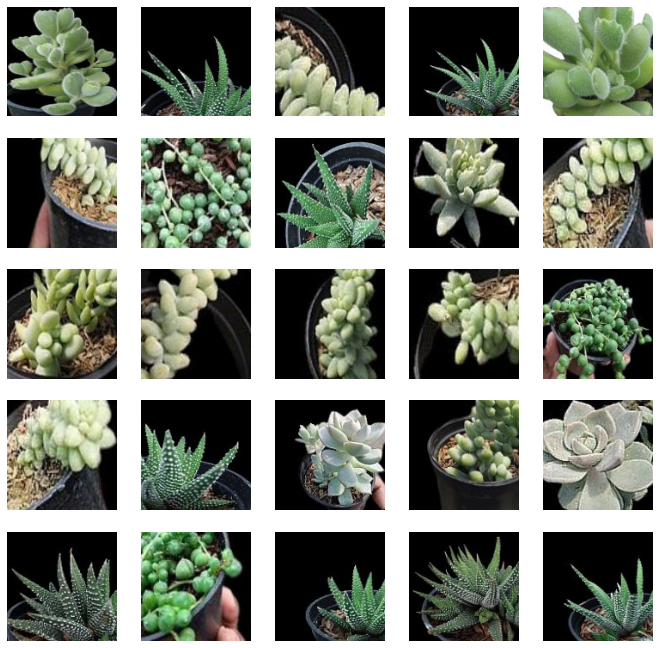

In [ ]:
import matplotlib.pyplot as plt

nrows = 5
ncols = 5
hspace = 0
wspace = 0
fig, ax = plt.subplots(nrows,ncols,figsize=(10,10))
fig.subplots_adjust(0,0)
for i in range(nrows):
  for j in range(ncols):
    ax[i,j].imshow(inputs[15*i*ncols+j])
    #ax[i,j].set_title(target[15*i*ncols+j])
    ax[i,j].axis('off')
plt.show()    

## Training Model dan K-Fold Cross Validation Model 1

In [ ]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=1)

akurasi_per_fold = []
loss_per_fold = []
fold = 1

for train,test in kfold.split(inputs,target):
  
  model = Sequential()

  model.add(Conv2D(20, (5, 5),
                  padding = "same", 
                  input_shape = input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))

  model.add(Conv2D(50, (5, 5),
                  padding = "same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dropout(0.2))
  model.add(Activation("relu"))

  model.add(Dense(128))
  model.add(Dropout(0.2))
  model.add(Activation("relu"))

  model.add(Dense(5))
  model.add(Dropout(0.2))
  model.add(Activation("softmax"))

  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Adam(learning_rate=0.0001),
                metrics = ['accuracy'])
      
  print('---------------------------------------------------------------')
  print(f'training for fold {fold} ...')

  history = model.fit(inputs[train], target[train],
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data = (inputs[test],target[test]))

  
  scores = model.evaluate(inputs[test], target[test], verbose=2)
  print(f'Score Evaluasi Per fold {fold} : loss : {scores[0]} dan akurasi :{scores[1]} ')
  akurasi_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold += 1

print('rata akurasi2 : ',np.mean(akurasi_per_fold))
print('rata loss : ',np.mean(loss_per_fold))


---------------------------------------------------------------
training for fold 1 ...
Epoch 1/20
75/75 [==============================] - 6s 43ms/step - loss: 1.1569 - accuracy: 0.5068 - val_loss: 0.2509 - val_accuracy: 0.9450
Epoch 2/20
75/75 [==============================] - 3s 37ms/step - loss: 0.4030 - accuracy: 0.8480 - val_loss: 0.0835 - val_accuracy: 0.9842
Epoch 3/20
75/75 [==============================] - 3s 37ms/step - loss: 0.2670 - accuracy: 0.8926 - val_loss: 0.0403 - val_accuracy: 0.9892
Epoch 4/20
75/75 [==============================] - 3s 37ms/step - loss: 0.2044 - accuracy: 0.9017 - val_loss: 0.0388 - val_accuracy: 0.9917
Epoch 5/20
75/75 [==============================] - 3s 37ms/step - loss: 0.1668 - accuracy: 0.9255 - val_loss: 0.0251 - val_accuracy: 0.9950
Epoch 6/20
75/75 [==============================] - 3s 37ms/step - loss: 0.1627 - accuracy: 0.9210 - val_loss: 0.0143 - val_accuracy: 0.9983
Epoch 7/20
75/75 [==============================] - 3s 39ms/step -

## Matrix Confussion dan Classification Report Model 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
prediksiNoDrop = model.predict(x_test.astype('float32'))
preediksiNpDrop = np.argmax(prediksiNoDrop,axis = 1)
print(confusion_matrix(y_test,preediksiNpDrop))
print(classification_report(y_test,preediksiNpDrop,target_names = label))

scores = model.evaluate(x_test, y_test, verbose=2)

[[271   0   0  27   2]
 [  0 253   0  47   0]
 [  0  59 214   0  27]
 [  0  12   0 265  23]
 [  0   0   0   0 300]]
              precision    recall  f1-score   support

   Cotyledon       1.00      0.90      0.95       300
   Echeveria       0.78      0.84      0.81       300
    Hawortia       1.00      0.71      0.83       300
       Sedum       0.78      0.88      0.83       300
     Senecio       0.85      1.00      0.92       300

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500

47/47 - 0s - loss: 0.4345 - accuracy: 0.8687


## Menampilkan Grafik Akurasi Model 1

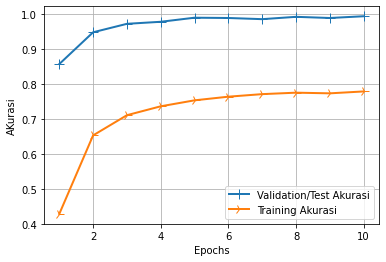

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Akurasi')
line2 = plt.plot(epochs, loss_values, label='Training Akurasi')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('AKurasi')
plt.grid(True)
plt.legend()
plt.show()

## Menampilkan Grafik Loss Model 1

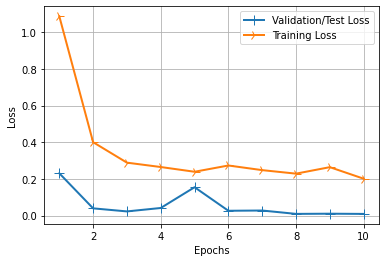

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Menyimpan Model 1 ke Google Drive

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/Model FIX/RGB/model_DP60_95.h5")

## Plot Model 1

In [ ]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model_diagrams_path = '/content/drive/My Drive/Colab Notebooks/Model/model1_NoDP_72.h5'

# Generate the plot
plot_model(model, to_file = model_diagrams_path + 'model_plot.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = mpimg.imread(model_diagrams_path + 'model_plot.png')
plt.figure(figsize=(30,15))
imgplot = plt.imshow(img) 

## Menguji Model 1 Menggunakan Data Baru

In [13]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import random

label = ['Cotyledon','Echeveria','Hawortia','Sedum','Senecio']

model = load_model('/content/drive/My Drive/Colab Notebooks/Model FIX/RGB/model_DP20_93.h5')

path = f'/content/drive/My Drive/Colab Notebooks/GambarInternet/H10.jpg'
    #print(path)m
img_width, img_height = 128, 128
img = image.load_img(path, target_size = (img_width, img_height))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Hasil Prediksi : {}"
    .format(label[np.argmax(score)])
)

Hasil Prediksi : Senecio


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import random

model = load_model('/content/drive/My Drive/Colab Notebooks/Model/FIX/FIX2/model1_DP40_85.h5')

prediksiNoDrop = model.predict(x_test.astype('float32'))
preediksiNpDrop = np.argmax(prediksiNoDrop,axis = 1)
print(confusion_matrix(y_test,preediksiNpDrop))
print(classification_report(y_test,preediksiNpDrop,target_names = label))

scores = model.evaluate(x_test, y_test, verbose=2)

[[288   0   0  12   0]
 [  0 275   0  25   0]
 [  0 156 144   0   0]
 [  0  18   2 275   5]
 [  0   0   0   2 298]]
              precision    recall  f1-score   support

   Cotyledon       1.00      0.96      0.98       300
   Echeveria       0.61      0.92      0.73       300
    Hawortia       0.99      0.48      0.65       300
       Sedum       0.88      0.92      0.90       300
     Senecio       0.98      0.99      0.99       300

    accuracy                           0.85      1500
   macro avg       0.89      0.85      0.85      1500
weighted avg       0.89      0.85      0.85      1500

47/47 - 0s - loss: 0.5422 - accuracy: 0.8533


# **Model 2 (Dataset Grayscale)**

## Import Library

In [ ]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.optimizers import RMSprop, SGD, Adam
import scipy
import os
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,KFold,cross_val_score,StratifiedKFold
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import random
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2
import pylab as pl
import matplotlib.cm as cm
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset Model 2 (Grayscale)

In [ ]:
dataTrain_dir = '/content/drive/My Drive/Colab Notebooks/Dataset 9/Data Train'
dataTest_dir = '/content/drive/My Drive/Colab Notebooks/Dataset 9/Data Test 2'
label = ['Cotyledon','Echeveria','Hawortia','Sedum','Senecio']

img_height = 128
img_width  = 128

data_train = []
data_test = []

def loadDataTrain(folder):
  for name in sorted(label):
    path = os.path.join(dataTrain_dir,name)
    no_label = label.index(name)
    for x in tqdm(sorted(os.listdir(path))):
      try:
        img_array = cv2.imread(os.path.join(path, x))
        RGBimg = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x = cv2.resize(RGBimg,(img_height,img_width))        
        data_train.append([x, no_label])
      except Exception as e:
        print(e)

def loadDataTest(folder):
  for name in sorted(label):
    path = os.path.join(dataTest_dir,name)
    no_label = label.index(name)
    for x in tqdm(sorted(os.listdir(path))):
      try:
        img_array = cv2.imread(os.path.join(path, x))
        RGBimg = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x = cv2.resize(RGBimg,(img_height,img_width))
        data_test.append([x, no_label])
      except Exception as e:
        print(e)

loadDataTrain(dataTrain_dir)
loadDataTest(dataTest_dir)

100%|██████████| 300/300 [00:00<00:00, 384.40it/s]


## Prepocessing Dataset Model 2


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []
for gambar, labels in data_train:
  x_train.append(gambar)
  y_train.append(labels)

for gambar, labels in data_test:
  x_test.append(gambar)
  y_test.append(labels)

x_train = np.array(x_train).reshape(-1,img_width,img_height,3)
x_test = np.array(x_test).reshape(-1,img_width,img_height,3)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

img_train,img_validasi, label_train,label_validasi = train_test_split(x_train,y_train, stratify = y_train, train_size = 0.8)

inputs = np.concatenate((img_train,img_validasi),axis = 0)
target = np.concatenate((label_train,label_validasi),axis = 0)

print (len(inputs))
print (len(target))



6000
6000


## Setting Parameter

In [ ]:
input_shape = x_test.shape[1:] #128x128x3
epochs = 20
batch_size = 64

## Plot Contoh Dataset yang digunakan untuk Model 2

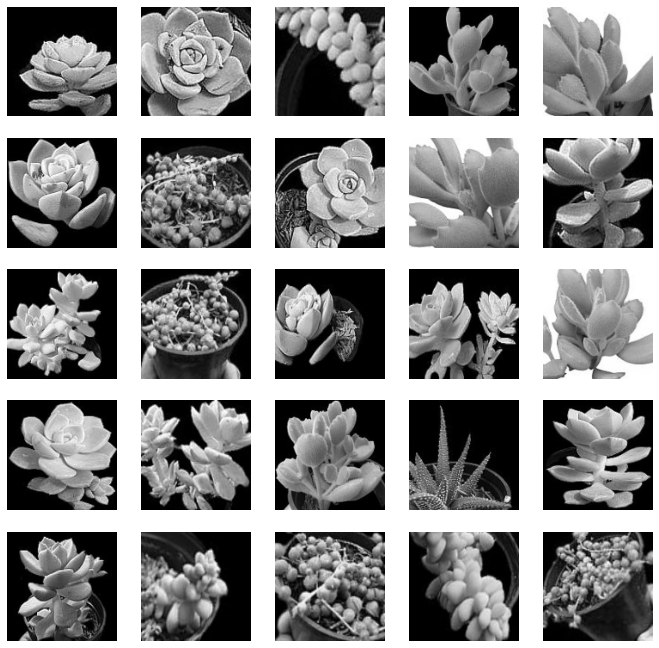

In [ ]:
import matplotlib.pyplot as plt

nrows = 5
ncols = 5
hspace = 0
wspace = 0
fig, ax = plt.subplots(nrows,ncols,figsize=(10,10))
fig.subplots_adjust(0,0)
for i in range(nrows):
  for j in range(ncols):
    ax[i,j].imshow(inputs[15*i*ncols+j])
    #ax[i,j].set_title(target[15*i*ncols+j])
    ax[i,j].axis('off')
plt.show()    

## Training Model 1 dan K - Fold Cross Validation

In [ ]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=1)

akurasi_per_fold = []
loss_per_fold = []
fold = 1

for train,test in kfold.split(inputs,target):
  
  model = Sequential()

  model.add(Conv2D(20, (5, 5),
                  padding = "same", 
                  input_shape = input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))

  model.add(Conv2D(50, (5, 5),
                  padding = "same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dropout(0.4))
  model.add(Activation("relu"))

  model.add(Dense(128))
  model.add(Dropout(0.4))
  model.add(Activation("relu"))

  model.add(Dense(5))
  model.add(Dropout(0.4))
  model.add(Activation("softmax"))

  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = Adam(learning_rate=0.01),
                metrics = ['accuracy'])
      
  print('---------------------------------------------------------------')
  print(f'training for fold {fold} ...')

  history = model.fit(inputs[train], target[train],
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data = (inputs[test],target[test]))

  
  scores = model.evaluate(inputs[test], target[test], verbose=2)
  print(f'Score Evaluasi Per fold {fold} : loss : {scores[0]} dan akurasi :{scores[1]} ')
  akurasi_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  fold += 1

print('rata akurasi2 : ',np.mean(akurasi_per_fold))
print('rata loss : ',np.mean(loss_per_fold))


---------------------------------------------------------------
training for fold 1 ...
Epoch 1/20
75/75 [==============================] - 6s 41ms/step - loss: 30.3604 - accuracy: 0.2152 - val_loss: 1.6095 - val_accuracy: 0.2050
Epoch 2/20
75/75 [==============================] - 3s 35ms/step - loss: 1.6098 - accuracy: 0.1947 - val_loss: 1.6103 - val_accuracy: 0.2033
Epoch 3/20
75/75 [==============================] - 3s 36ms/step - loss: 1.6112 - accuracy: 0.1935 - val_loss: 1.6095 - val_accuracy: 0.1958
Epoch 4/20
75/75 [==============================] - 3s 35ms/step - loss: 1.6094 - accuracy: 0.2140 - val_loss: 1.6098 - val_accuracy: 0.2033
Epoch 5/20
75/75 [==============================] - 3s 35ms/step - loss: 1.6105 - accuracy: 0.1936 - val_loss: 1.6095 - val_accuracy: 0.2033
Epoch 6/20
75/75 [==============================] - 3s 36ms/step - loss: 1.6100 - accuracy: 0.1952 - val_loss: 1.6102 - val_accuracy: 0.2050
Epoch 7/20
75/75 [==============================] - 3s 37ms/step 

## Matrix Confussion dan Classification Report Model 2

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
prediksiNoDrop = model.predict(x_test.astype('float32'))
preediksiNpDrop = np.argmax(prediksiNoDrop,axis = 1)
print(confusion_matrix(y_test,preediksiNpDrop))
print(classification_report(y_test,preediksiNpDrop,target_names = label))

scores = model.evaluate(x_test, y_test, verbose=2)

[[  0 300   0   0   0]
 [  0 300   0   0   0]
 [  0 300   0   0   0]
 [  0 300   0   0   0]
 [  0 300   0   0   0]]
              precision    recall  f1-score   support

   Cotyledon       0.00      0.00      0.00       300
   Echeveria       0.20      1.00      0.33       300
    Hawortia       0.00      0.00      0.00       300
       Sedum       0.00      0.00      0.00       300
     Senecio       0.00      0.00      0.00       300

    accuracy                           0.20      1500
   macro avg       0.04      0.20      0.07      1500
weighted avg       0.04      0.20      0.07      1500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


47/47 - 0s - loss: 1.6097 - accuracy: 0.2000


## Menampilkan Grafik Akurasi Model

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['accuracy']
val_loss_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Akurasi')
line2 = plt.plot(epochs, loss_values, label='Training Akurasi')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('AKurasi')
plt.grid(True)
plt.legend()
plt.show()

## Menampilkan Grafik Loss Model

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## Menyimpan Model

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/Model FIX/Grayscale/model_GSDP40_64.h5")

## Memplot Model

In [ ]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model_diagrams_path = '/content/drive/My Drive/Colab Notebooks/Model/model1_NoDP_72.h5'

# Generate the plot
plot_model(model, to_file = model_diagrams_path + 'model_plot.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = mpimg.imread(model_diagrams_path + 'model_plot.png')
plt.figure(figsize=(30,15))
imgplot = plt.imshow(img) 

## Menguji Model dengan data baru dari internet